# GRU com Attention (Soma das Próximas 4 Semanas)

Este notebook implementa o modelo GRU com camada de atenção para previsão da **soma das próximas 4 semanas** (previsão mensal) das taxas de morbidade respiratória em municípios brasileiros.

- **Modelo:** GRU com Attention
- **Alvo:** Soma das próximas 4 semanas (previsão mensal)
- **Input:** sequência de 24 semanas (shape: [batch, 24, 1])
- **Arquitetura:** GRU(64, return_sequences=True) → Attention Layer → Dense(1)
- **Perda:** MAE
- **Todo o código é modular e importado dos módulos `src/`.**

In [1]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"Project root: {project_root}")

# Add the project root to sys.path (not the src directory)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to sys.path")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from src.preprocessing import load_city_data, prepare_data_for_model, filter_city, clean_timeseries
from src.models import build_gru_attention
from src.train import train_model, evaluate_model, generate_forecasts, save_predictions, save_metrics
from src.utils import plot_forecast, plot_forecast_error, plot_training_history

results_dir = os.path.join('results', 'gru_attention')
os.makedirs(results_dir, exist_ok=True)

np.random.seed(42)

Project root: c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models
Added c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models to sys.path


## Estrutura do Repositório

- **data/**: Um CSV por cidade, cada um com coluna de data, coluna alvo e features opcionais.
- **notebooks/**: Notebooks para cada experimento. Apenas visualização e exploração.
- **src/**: Módulos reutilizáveis:
    - `preprocessing.py`: Carregamento, normalização, split, criação de janelas
    - `models.py`: Definições de modelos (baselines, MLP, LSTM, etc.)
    - `train.py`: Rotinas de treino e avaliação
    - `utils.py`: Funções auxiliares (plot, métricas, etc.)
- **results/**: Previsões e métricas salvas.
- **instructions.md**: Guia de boas práticas.

**Toda a lógica central está em `src/`.**

## Carregamento e Exploração dos Dados

Carregue os dados de morbidade respiratória para análise. Você pode iterar sobre todas as cidades ou selecionar uma específica.

In [ ]:
# Exemplo: Carregar dados de uma cidade (ajuste o caminho conforme necessário)
data_path = '../data/df_base_morb_resp.csv'
df = load_city_data(data_path)

print(f"Formato do dataset: {df.shape}")
df.head()

In [ ]:
print("Colunas disponíveis:")
print(df.columns.tolist())
df.describe()

## Seleção e Limpeza de Cidade

Selecione uma cidade específica para modelagem e limpe a série temporal.

In [4]:
# Select city for modeling (set to None to use all cities)
CD_MUN_SELECTED = 3550308  # São Paulo

df_city = filter_city(df, cd_mun=CD_MUN_SELECTED)
df_city = clean_timeseries(df_city, target_column='target')
print(f"Selected city shape: {df_city.shape}")

Selected city shape: (1200, 11)


## Pré-processamento

Prepare os dados para o modelo GRU com Attention. O input é uma sequência de 24 semanas.

In [5]:
model_params = {
    'sequence_length': 12,
    'forecast_horizon': 4,  # Soma das próximas 4 semanas (previsão mensal)
    'normalization': 'zscore',
    'val_size': None
}

target_column = 'target'

data_dict = prepare_data_for_model(
    df=df_city,
    target_column=target_column,
    sequence_length=model_params['sequence_length'],
    forecast_horizon=model_params['forecast_horizon'],
    normalization=model_params['normalization'],
    val_size=model_params.get('val_size', None)
)

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict.get('X_val', None)
y_val = data_dict.get('y_val', None)
X_test = data_dict['X_test']
y_test = data_dict['y_test']
test_df = data_dict['test_df']
scaler = data_dict.get('scaler')
feature_columns = data_dict.get('feature_columns', None)

## Definição e Treinamento do Modelo

O modelo GRU com Attention utiliza uma camada GRU seguida de uma camada de atenção customizada.

In [ ]:
input_shape = X_train.shape[1:]
model = build_gru_attention(input_shape=input_shape, loss='mae')

history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=32,
    epochs=400,
    patience=35,
    verbose=1
)

## Avaliação do Modelo

Calcule MAE, RMSE e R² para o modelo GRU com Attention.

In [8]:
metrics = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler
)

print("Métricas de Avaliação:")
print(f"MAE: {metrics['mae']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"R²: {metrics['r2']:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Métricas de Avaliação:
MAE: 84.6325
RMSE: 117.5545
R²: -0.2672
Métricas de Avaliação:
MAE: 84.6325
RMSE: 117.5545
R²: -0.2672


## Visualização dos Resultados

Plote os valores reais versus previstos e o erro de previsão. O alvo é a **soma das próximas 4 semanas** (previsão mensal).

In [9]:
def reduce_to_1d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr
    if arr.ndim == 2:
        if arr.shape[1] == 1:
            return arr.ravel()
        else:
            return arr.sum(axis=1)
    raise ValueError(f"Unexpected array shape: {arr.shape}")

# Always define robust 1D, denormalized arrays for all plots and DataFrames
y_test_1d = reduce_to_1d(y_test)
y_pred = generate_forecasts(model, X_test)
y_pred_1d = reduce_to_1d(y_pred)
if scaler is not None and hasattr(scaler, 'scale_') and hasattr(scaler, 'mean_'):
    if scaler.scale_.shape[0] > 1:
        y_test_1d = y_test_1d * scaler.scale_[0] + scaler.mean_[0]
        y_pred_1d = y_pred_1d * scaler.scale_[0] + scaler.mean_[0]
    else:
        y_test_1d = scaler.inverse_transform(y_test_1d.reshape(-1, 1)).flatten()
        y_pred_1d = scaler.inverse_transform(y_pred_1d.reshape(-1, 1)).flatten()

test_dates = test_df['week'].values[-len(y_test_1d):] if 'week' in test_df.columns else np.arange(len(y_test_1d))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


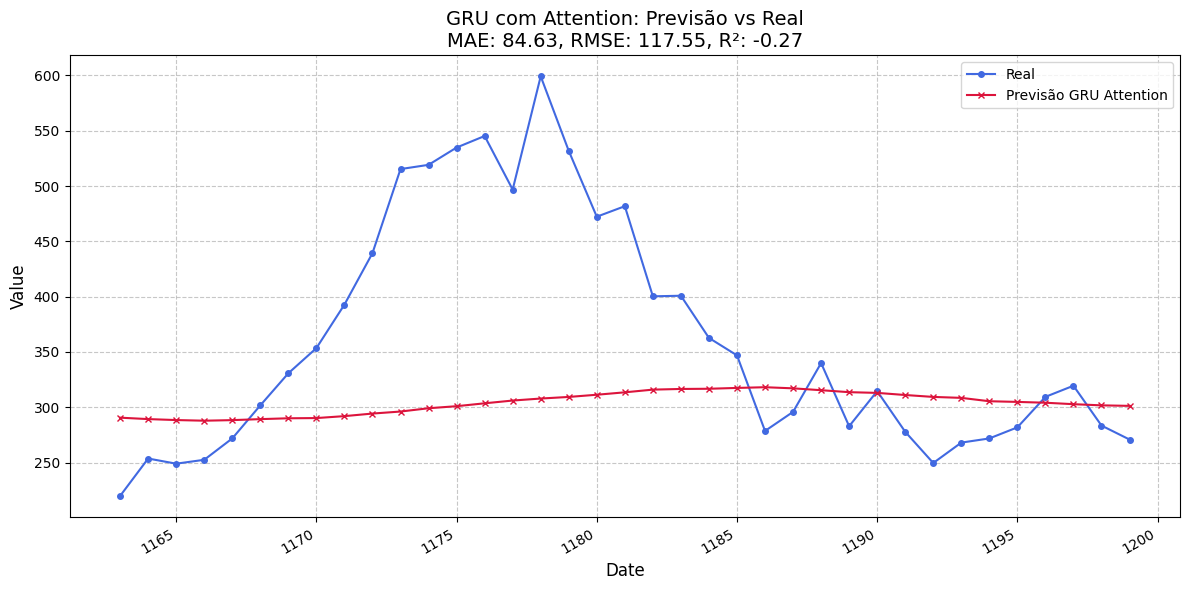

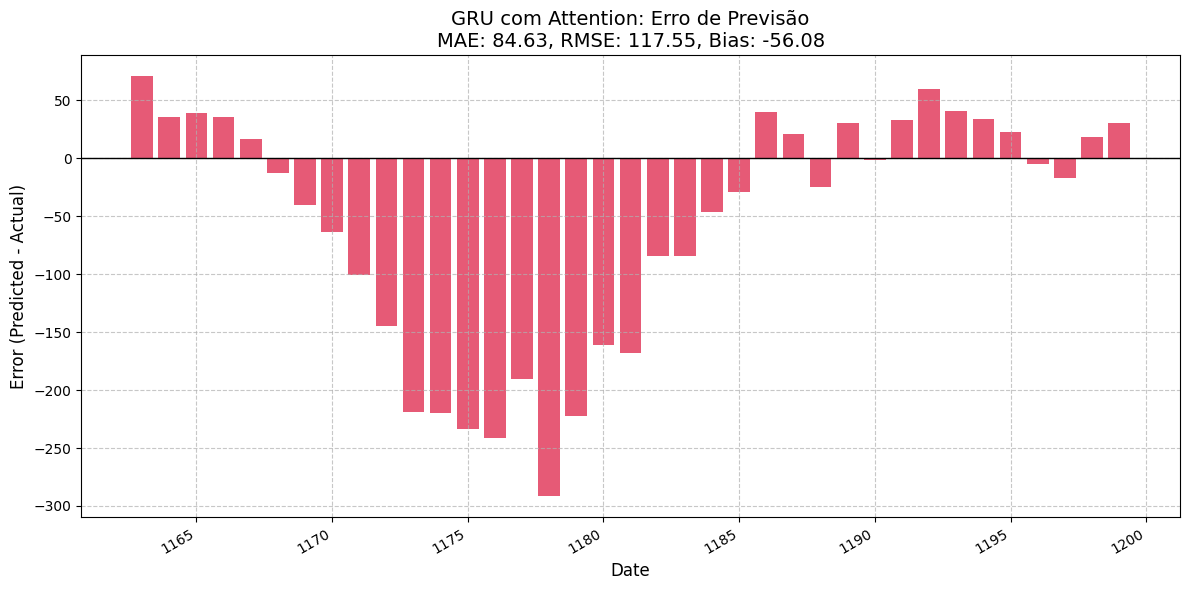

C:\Users\pedro\AppData\Local\Temp\ipykernel_8124\712609095.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\pedro\AppData\Local\Temp\ipykernel_8124\712609095.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


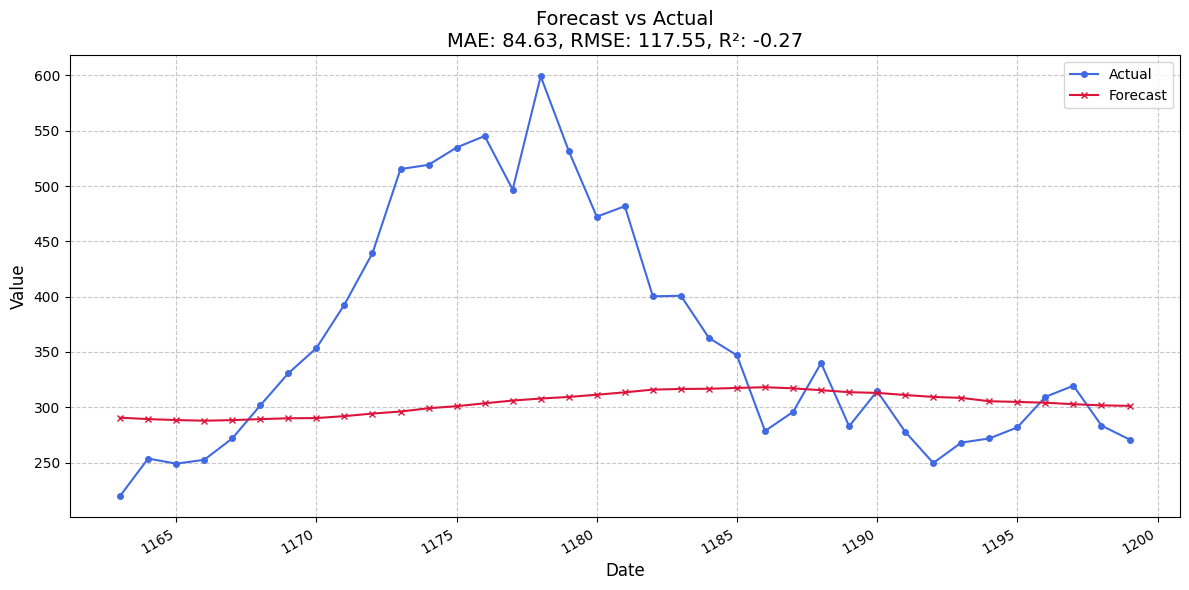

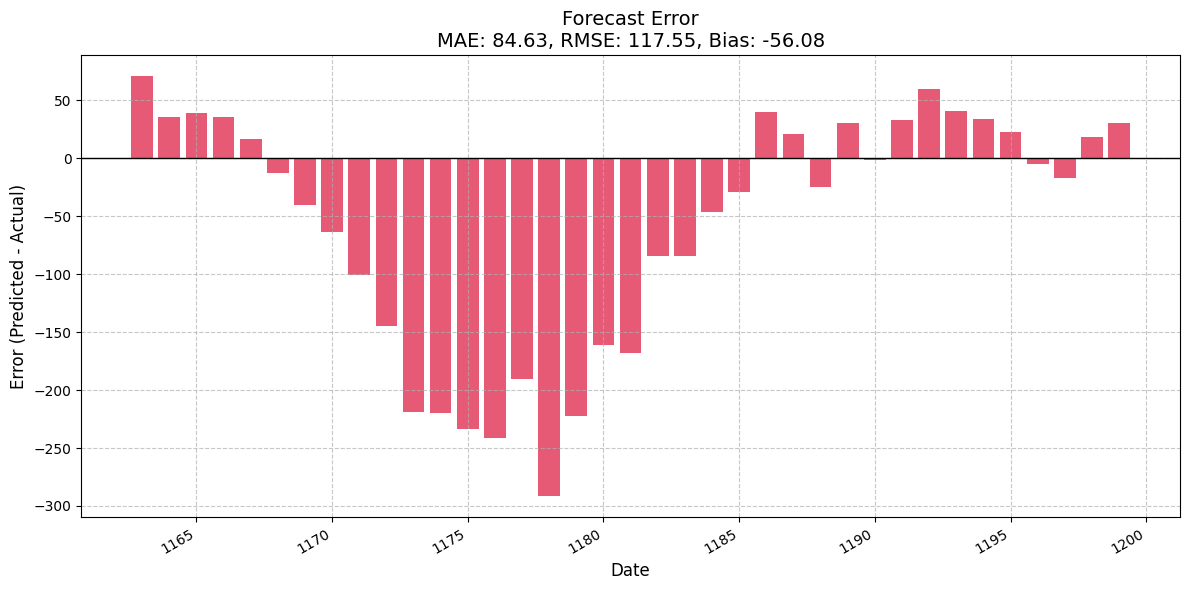

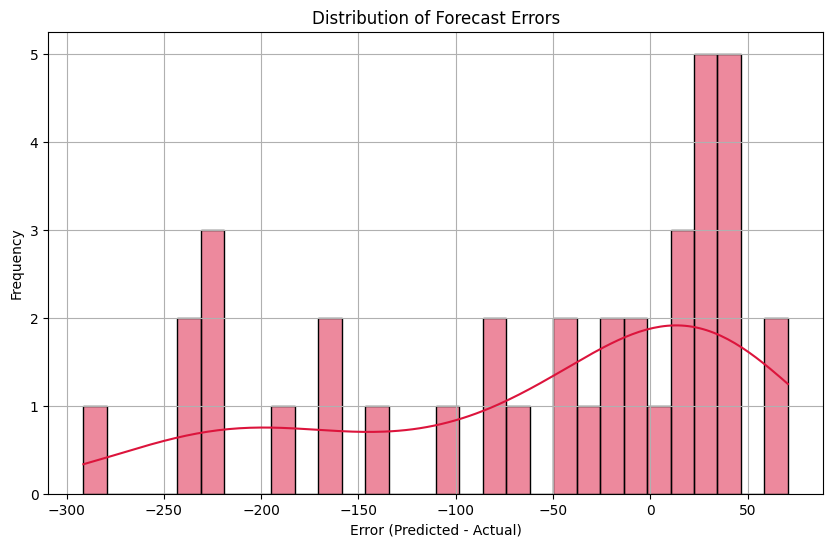

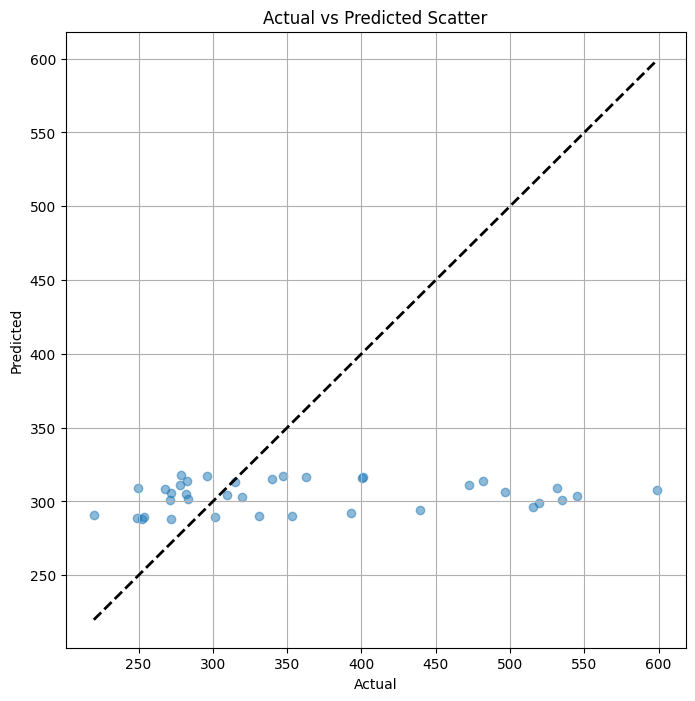

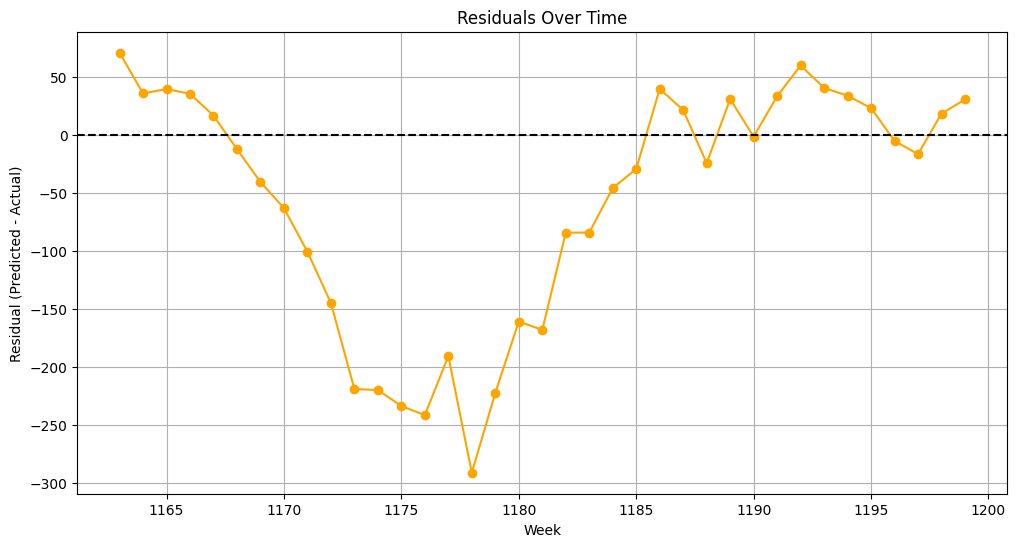

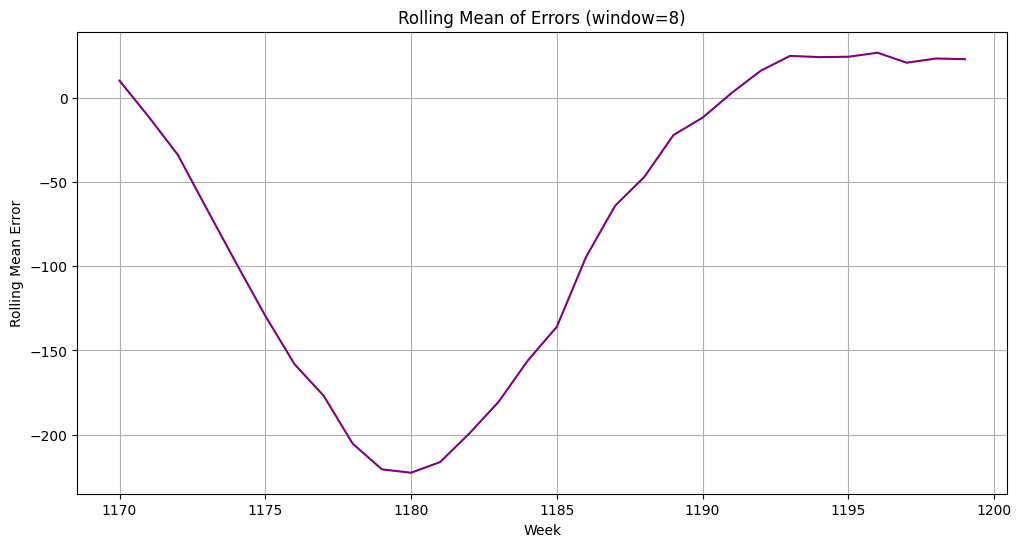

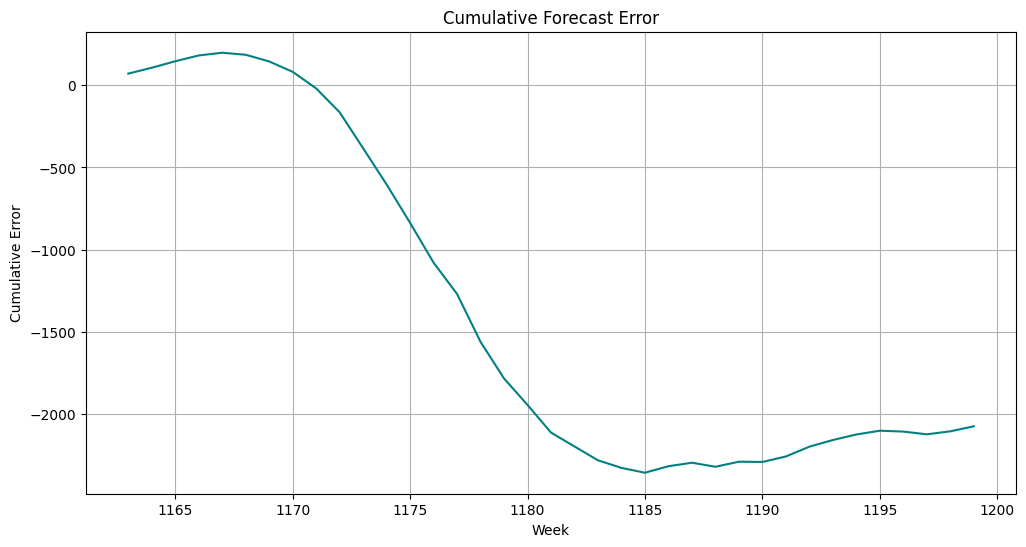

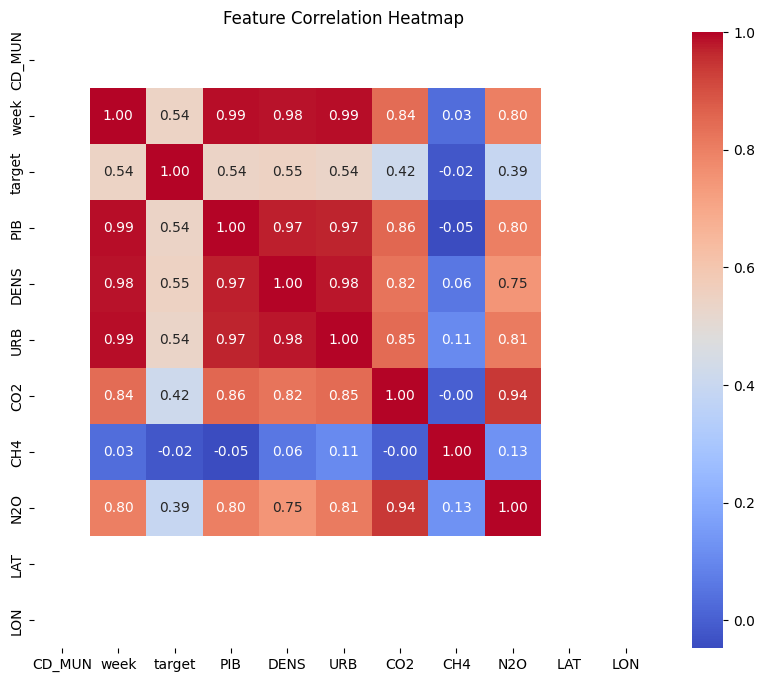

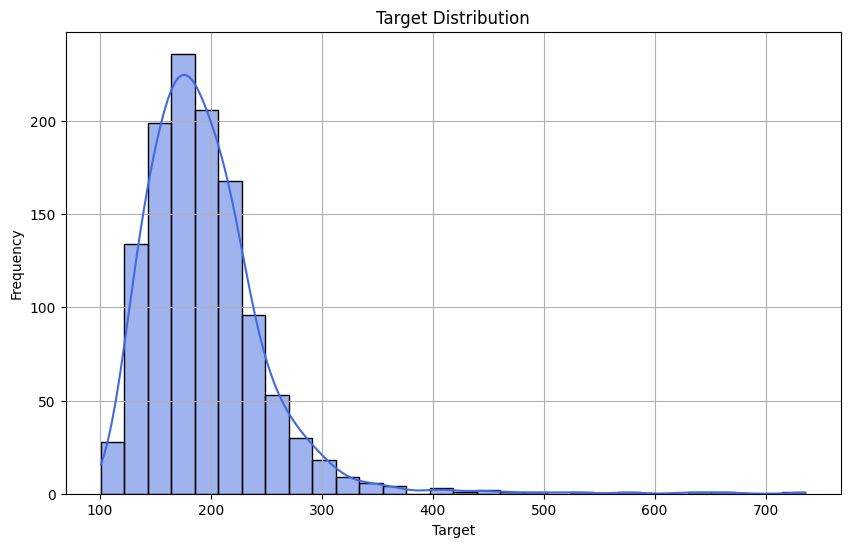

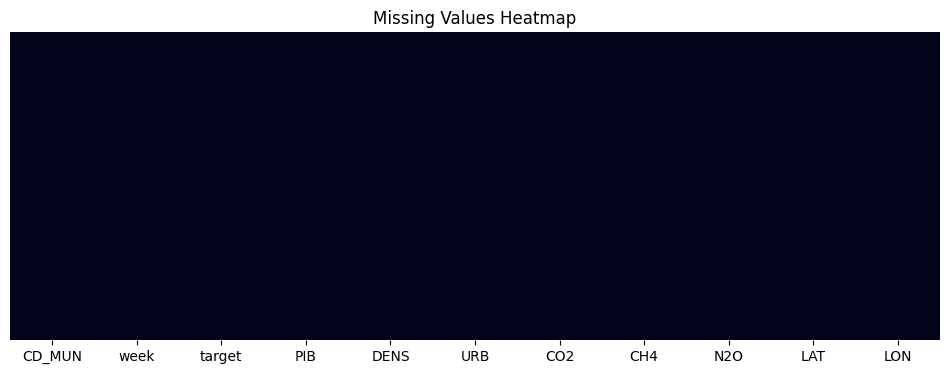

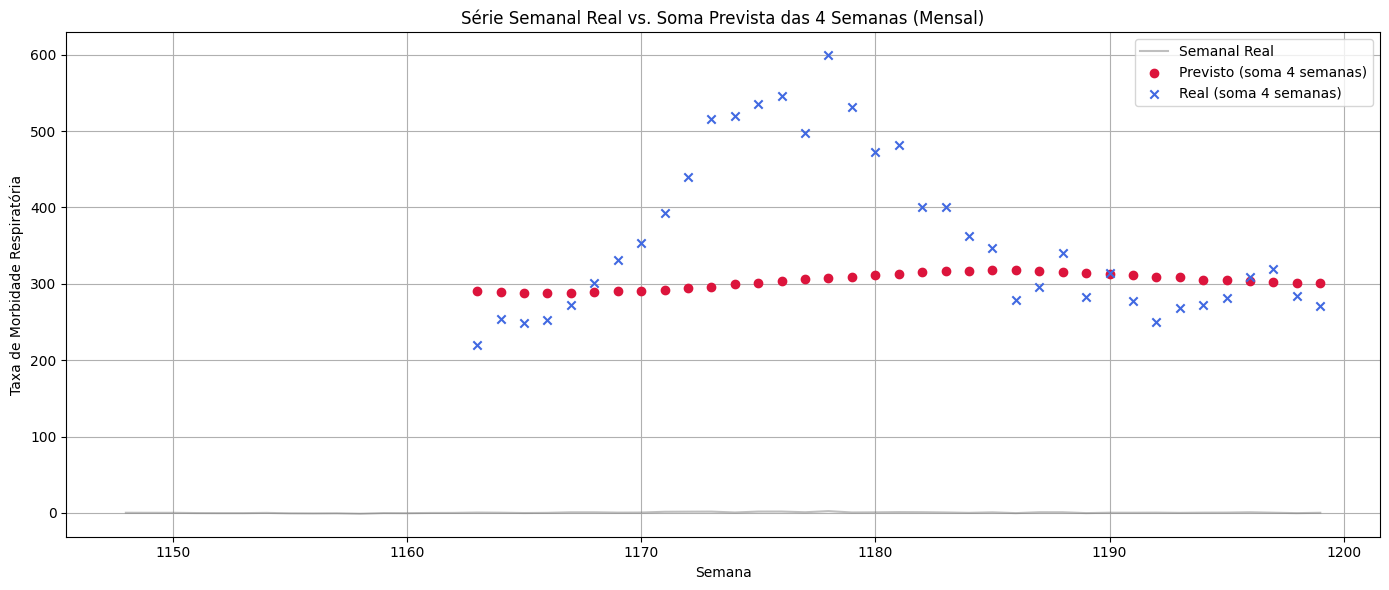

,week,y_test (soma 4 sem),y_pred (soma 4 sem)
0,1163,219.855000,290.610201
1,1164,253.666565,289.324716
2,1165,249.009526,288.456612
3,1166,252.523883,287.868219
4,1167,271.855000,288.393569
5,1168,301.740406,289.292702
6,1169,330.766515,290.054180
7,1170,353.508928,290.255107
8,1171,392.855000,292.008811
9,1172,439.400460,294.327236


In [10]:
def reduce_to_1d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr
    if arr.ndim == 2:
        if arr.shape[1] == 1:
            return arr.ravel()
        else:
            return arr.sum(axis=1)
    raise ValueError(f"Unexpected array shape: {arr.shape}")

# Always define robust 1D, denormalized arrays for all plots and DataFrames
y_test_1d = reduce_to_1d(y_test)
y_pred = generate_forecasts(model, X_test)
y_pred_1d = reduce_to_1d(y_pred)
if scaler is not None and hasattr(scaler, 'scale_') and hasattr(scaler, 'mean_'):
    if scaler.scale_.shape[0] > 1:
        y_test_1d = y_test_1d * scaler.scale_[0] + scaler.mean_[0]
        y_pred_1d = y_pred_1d * scaler.scale_[0] + scaler.mean_[0]
    else:
        y_test_1d = scaler.inverse_transform(y_test_1d.reshape(-1, 1)).flatten()
        y_pred_1d = scaler.inverse_transform(y_pred_1d.reshape(-1, 1)).flatten()

# Get time axis for the test set
test_dates = test_df['week'].values[-len(y_test_1d):] if 'week' in test_df.columns else np.arange(len(y_test_1d))

# Previsões
fig1 = plot_forecast(
    true_values=y_test_1d,
    predictions=y_pred_1d,
    dates=test_dates,
    title="GRU com Attention: Previsão vs Real",
    true_label="Real",
    pred_label="Previsão GRU Attention"
)
plt.savefig(os.path.join(results_dir, 'forecast_plot.png'))
plt.show()

fig2 = plot_forecast_error(
    true_values=y_test_1d,
    predictions=y_pred_1d,
    dates=test_dates,
    title="GRU com Attention: Erro de Previsão"
)
plt.savefig(os.path.join(results_dir, 'error_plot.png'))
plt.show()

# --- Advanced Evaluation and Visualization ---

# 1. Forecast vs Actual
fig1 = plot_forecast(y_test_1d, y_pred_1d, dates=test_dates, title="Forecast vs Actual")
fig1.show()

# 2. Forecast Error
fig2 = plot_forecast_error(y_test_1d, y_pred_1d, dates=test_dates, title="Forecast Error")
fig2.show()

# 3. Distribution of Errors
errors = y_pred_1d - y_test_1d
plt.figure(figsize=(10,6))
sns.histplot(errors, kde=True, bins=30, color='crimson')
plt.title('Distribution of Forecast Errors')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,8))
plt.scatter(y_test_1d, y_pred_1d, alpha=0.5)
plt.plot([y_test_1d.min(), y_test_1d.max()], [y_test_1d.min(), y_test_1d.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Scatter')
plt.grid(True)
plt.show()

# 5. Residuals Over Time
plt.figure(figsize=(12,6))
plt.plot(test_dates, errors, marker='o', linestyle='-', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Week')
plt.ylabel('Residual (Predicted - Actual)')
plt.grid(True)
plt.show()

# 6. Rolling Mean of Errors
window = 8
rolling_error = pd.Series(errors).rolling(window=window).mean()
plt.figure(figsize=(12,6))
plt.plot(test_dates, rolling_error, color='purple')
plt.title(f'Rolling Mean of Errors (window={window})')
plt.xlabel('Week')
plt.ylabel('Rolling Mean Error')
plt.grid(True)
plt.show()

# 7. Cumulative Error
cumulative_error = np.cumsum(errors)
plt.figure(figsize=(12,6))
plt.plot(test_dates, cumulative_error, color='teal')
plt.title('Cumulative Forecast Error')
plt.xlabel('Week')
plt.ylabel('Cumulative Error')
plt.grid(True)
plt.show()

# 8. Feature Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_city.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 9. Target Distribution
plt.figure(figsize=(10,6))
sns.histplot(df_city['target'], kde=True, bins=30, color='royalblue')
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 10. Missing Values Heatmap
plt.figure(figsize=(12,4))
sns.heatmap(df_city.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

# Overlay plot: Série semanal real e soma prevista das 4 semanas
plt.figure(figsize=(14,6))
plt.plot(test_df['week'], test_df['target'], label='Semanal Real', color='gray', alpha=0.5)
plt.scatter(test_df['week'].values[-len(y_pred_1d):], y_pred_1d, label='Previsto (soma 4 semanas)', color='crimson', zorder=3)
plt.scatter(test_df['week'].values[-len(y_test_1d):], y_test_1d, label='Real (soma 4 semanas)', color='royalblue', marker='x', zorder=3)
plt.title('Série Semanal Real vs. Soma Prevista das 4 Semanas (Mensal)')
plt.xlabel('Semana')
plt.ylabel('Taxa de Morbidade Respiratória')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Diagnóstico: Verificar alinhamento de y_test e y_pred
N = 10
week_idx = test_df['week'].values[-len(y_test_1d):]
df_diag = pd.DataFrame({
    'week': week_idx[:N],
    'y_test (soma 4 sem)': y_test_1d[:N],
    'y_pred (soma 4 sem)': y_pred_1d[:N]
})
display(df_diag)

## Salvar Resultados

Salve as previsões e métricas para comparação posterior.

In [11]:
# Salvar previsões
preds_file = save_predictions(
    y_true=y_test_1d,
    y_pred=y_pred_1d,
    dates=test_dates,
    city_name='São Paulo',
    model_name='gru_attention',
    output_dir=results_dir
)
print(f"Previsões salvas em: {preds_file}")

# Salvar métricas
metrics_file = save_metrics(
    metrics=metrics,
    city_name='São Paulo',
    model_name='gru_attention',
    output_dir=results_dir,
    params=model_params
)
print(f"Métricas salvas em: {metrics_file}")

Previsões salvas em: results\gru_attention\São Paulo_gru_attention_preds.csv
Métricas salvas em: results\gru_attention\São Paulo_gru_attention_metrics.csv


## Conclusão

O modelo GRU com Attention permite captar padrões temporais complexos e múltiplos lags. Compare seu desempenho com outros modelos nos próximos notebooks.

In [1]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0
